In [34]:
pip install matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


 Import Required Libraries

In [1]:
from surprise import SVD, Dataset, Reader
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse


Load and Clean Ratings Data

In [2]:
# Load Ratings.csv with semicolon separator
ratings = pd.read_csv("Ratings.csv", sep=';')

# Keep only relevant columns
ratings = ratings[['User-ID', 'ISBN', 'Rating']]

# Filter out entries with no rating
ratings = ratings[ratings['Rating'] > 0]

# Show the first few entries
ratings.head()




,User-ID,ISBN,Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


Prepare Dataset for Surprise

In [3]:
# Sample a smaller dataset to speed things up
sampled_ratings = ratings.sample(n=10000, random_state=42)

# Define the rating scale
reader = Reader(rating_scale=(1, 10))

# Load dataset into Surprise
data = Dataset.load_from_df(sampled_ratings[['User-ID', 'ISBN', 'Rating']], reader)

# Split into training and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)





 Train the SVD Model

In [4]:
# Initialize the SVD model (Singular Value Decomposition)
model = SVD()

# Train the model on the training data
model.fit(trainset)


Evaluate Model Performance

In [5]:
# Make predictions on the test set
predictions = model.test(testset)

# Calculate RMSE (Root Mean Squared Error)
rmse(predictions)


RMSE: 1.7894


1.7894088952695557

Function to Get Top-N Recommendations

In [6]:
def get_top_n_recommendations(predictions, n=5):
    from collections import defaultdict

    # Map each user to the list of predicted ratings for unseen books
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort and get top-n for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n


Predict Top-N for a Specific User

In [7]:
# Pick a specific user from your sampled data
target_user = sampled_ratings['User-ID'].iloc[0]  # or use a known ID like '276729'

# Get books the user hasn't rated
rated_books = set(sampled_ratings[sampled_ratings['User-ID'] == target_user]['ISBN'])
all_books = set(sampled_ratings['ISBN'].unique())
unrated_books = list(all_books - rated_books)

# Predict ratings only for those unrated books
user_predictions = []
for isbn in unrated_books:
    pred = model.predict(str(target_user), str(isbn))
    user_predictions.append((isbn, pred.est))

# Get top 5
top_n = sorted(user_predictions, key=lambda x: x[1], reverse=True)[:5]

# Display recommendations
print(f"Top 5 book recommendations for user {target_user}:")
for isbn, rating in top_n:
    print(f"ISBN: {isbn} | Predicted Rating: {round(rating, 2)}")



Top 5 book recommendations for user 32440:
ISBN: 0316666343 | Predicted Rating: 8.33
ISBN: 059035342X | Predicted Rating: 8.21
ISBN: 0380813815 | Predicted Rating: 8.15
ISBN: 0440221471 | Predicted Rating: 8.15
ISBN: 0060930535 | Predicted Rating: 8.14


Display Details of Books

In [13]:
# Load book info
books = pd.read_csv("Books.csv", sep=';', encoding='latin-1')
books.columns

# Keep only useful columns
books = books[['ISBN', 'Title', 'Author','Year','Publisher']]

# Drop duplicates just in case
books = books.drop_duplicates(subset='ISBN')

# Preview
books.head()


,ISBN,Title,Author,Year,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


 Convert top ISBNs to Titles

In [26]:
print(f"\nTop 5 book recommendations for user {target_user}:")

for isbn, rating in top_n:
    book_info = books[books['ISBN'] == isbn]

    if not book_info.empty:
        title = book_info.iloc[0]['Title']
        author = book_info.iloc[0]['Author']
        year = book_info.iloc[0]['Year']
        publisher = book_info.iloc[0]['Publisher']
        print(f"{title} by {author} ({year}, {publisher}) | Predicted Rating: {round(rating, 2)}")
    else:
        print(f"ISBN: {isbn} | Predicted Rating: {round(rating, 2)}")




Top 5 book recommendations for user 32440:
The Lovely Bones: A Novel by Alice Sebold (2002, Little, Brown) | Predicted Rating: 8.33
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) by J. K. Rowling (1999, Arthur A. Levine Books) | Predicted Rating: 8.21
Lamb : The Gospel According to Biff, Christ's Childhood Pal by Christopher Moore (2003, Perennial) | Predicted Rating: 8.15
The Runaway Jury by JOHN GRISHAM (1997, Dell) | Predicted Rating: 8.15
The Poisonwood Bible: A Novel by Barbara Kingsolver (1999, Perennial) | Predicted Rating: 8.14


Use the User ID that exists

In [29]:
sampled_ratings['User-ID'].unique()


array([ 32440,  49144, 156424, ..., 227672,  16095, 141203], dtype=int64)

 Add this cell to take input and generate recommendations:

In [31]:
# Get input from user
target_user = input("Enter User-ID: ")

# Convert to string (just in case it's numeric)
target_user = str(target_user)

# Check if user exists
if target_user in sampled_ratings['User-ID'].astype(str).unique():
    rated_books = set(sampled_ratings[sampled_ratings['User-ID'].astype(str) == target_user]['ISBN'])
    all_books = set(sampled_ratings['ISBN'].unique())
    unrated_books = list(all_books - rated_books)

    user_predictions = []
    for isbn in unrated_books:
        pred = model.predict(target_user, isbn)
        user_predictions.append((isbn, pred.est))

    # Get top 5
    top_n = sorted(user_predictions, key=lambda x: x[1], reverse=True)[:5]

    # Show recommendations with details
    print(f"\nTop 5 book recommendations for user {target_user}:")
    for isbn, rating in top_n:
        book_info = books[books['ISBN'] == isbn]

        if not book_info.empty:
            row = book_info.iloc[0]
            print(f"{row['Title']} by {row['Author']} "
                  f"({row['Year']}, {row['Publisher']}) | Predicted Rating: {round(rating, 2)}")
        else:
            print(f"ISBN: {isbn} | Predicted Rating: {round(rating, 2)}")

else:
    print(f"User-ID {target_user} not found in dataset.")


Enter User-ID:  16095



Top 5 book recommendations for user 16095:
The Lovely Bones: A Novel by Alice Sebold (2002, Little, Brown) | Predicted Rating: 8.33
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) by J. K. Rowling (1999, Arthur A. Levine Books) | Predicted Rating: 8.21
Lamb : The Gospel According to Biff, Christ's Childhood Pal by Christopher Moore (2003, Perennial) | Predicted Rating: 8.15
The Runaway Jury by JOHN GRISHAM (1997, Dell) | Predicted Rating: 8.15
The Poisonwood Bible: A Novel by Barbara Kingsolver (1999, Perennial) | Predicted Rating: 8.14


Show Top-Rated Books Overall

In [32]:
# Merge ratings with books
merged = pd.merge(sampled_ratings, books, on='ISBN')

# Group by Title and Author
book_stats = merged.groupby(['Title', 'Author']).agg({
    'Rating': ['mean', 'count']
}).reset_index()

# Rename columns
book_stats.columns = ['Title', 'Author', 'Avg_Rating', 'Num_Ratings']

# Filter out books with very few ratings (e.g., less than 10)
popular_books = book_stats[book_stats['Num_Ratings'] >= 10]

# Sort by highest average rating
top_books = popular_books.sort_values(by='Avg_Rating', ascending=False).head(10)

print("📚 Top Rated Books (with at least 10 ratings):\n")
for _, row in top_books.iterrows():
    print(f"{row['Title']} by {row['Author']} — {round(row['Avg_Rating'], 2)} (based on {row['Num_Ratings']} ratings)")


📚 Top Rated Books (with at least 10 ratings):

The Lovely Bones: A Novel by Alice Sebold — 8.82 (based on 11 ratings)
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) by J. K. Rowling — 8.8 (based on 10 ratings)
To Kill a Mockingbird by Harper Lee — 8.58 (based on 12 ratings)
Snow Falling on Cedars by David Guterson — 8.4 (based on 10 ratings)
Fahrenheit 451 by RAY BRADBURY — 8.33 (based on 12 ratings)
Wicked: The Life and Times of the Wicked Witch of the West by Gregory Maguire — 8.2 (based on 10 ratings)
Life of Pi by Yann Martel — 8.17 (based on 12 ratings)
Bridget Jones's Diary by Helen Fielding — 7.73 (based on 15 ratings)
The Nanny Diaries: A Novel by Emma McLaughlin — 7.5 (based on 14 ratings)
The Summons by John Grisham — 7.1 (based on 10 ratings)


Most Active Users

C:\Users\Muskan\AppData\Local\Temp\ipykernel_24464\3610881474.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user_counts.index, y=user_counts.values, palette='viridis')


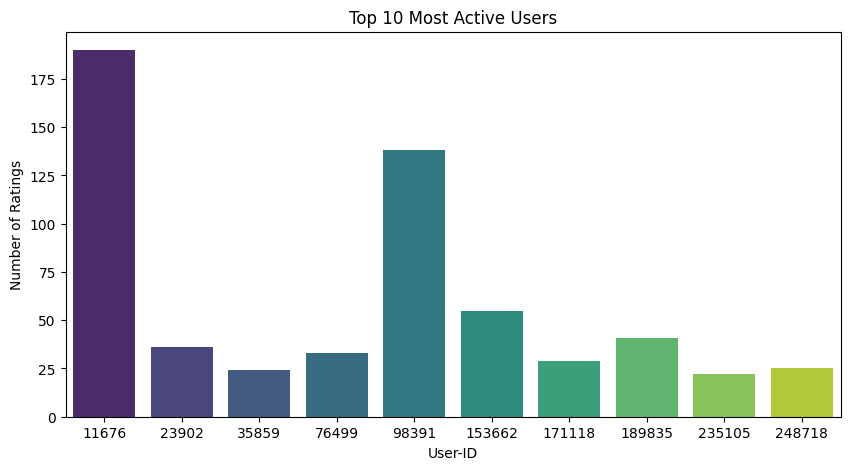

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count ratings per user
user_counts = sampled_ratings['User-ID'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=user_counts.index, y=user_counts.values, palette='viridis')
plt.title("Top 10 Most Active Users")
plt.xlabel("User-ID")
plt.ylabel("Number of Ratings")
plt.show()


Most Rated Books

C:\Users\Muskan\AppData\Local\Temp\ipykernel_24464\1479552464.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_books.index, x=top_books.values, palette='magma')


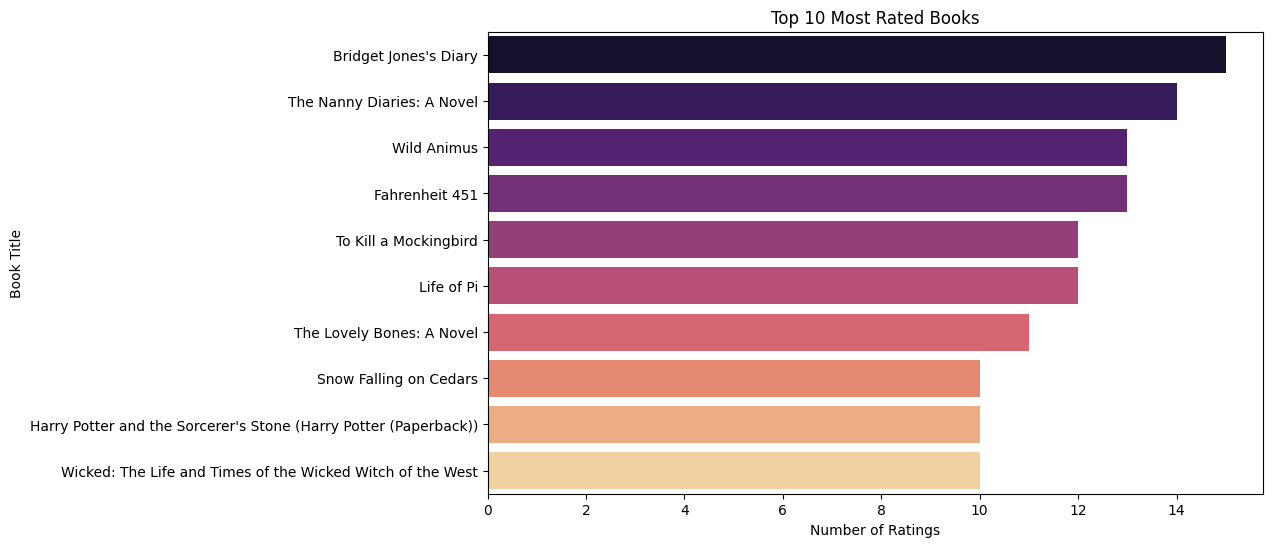

In [37]:
top_books = merged['Title'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(y=top_books.index, x=top_books.values, palette='magma')
plt.title("Top 10 Most Rated Books")
plt.xlabel("Number of Ratings")
plt.ylabel("Book Title")
plt.show()


Top Rated Authors

C:\Users\Muskan\AppData\Local\Temp\ipykernel_24464\1259754604.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_authors, x='Avg_Rating', y='Author', palette='crest')


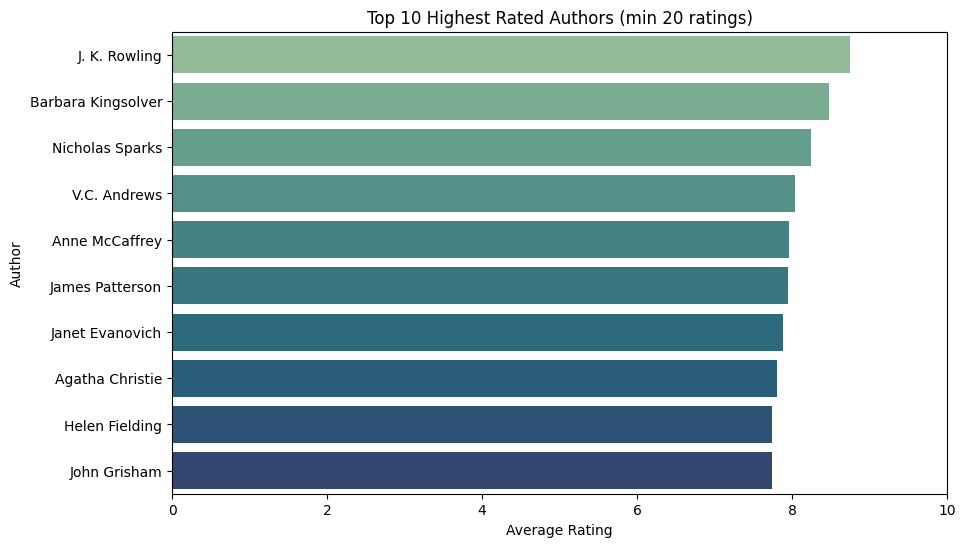

In [38]:
# Merge ratings and books
merged = pd.merge(sampled_ratings, books, on='ISBN')

# Group by author and compute average rating + count
author_stats = merged.groupby('Author').agg({
    'Rating': ['mean', 'count']
}).reset_index()

# Rename columns
author_stats.columns = ['Author', 'Avg_Rating', 'Num_Ratings']

# Filter authors with at least 20 ratings
popular_authors = author_stats[author_stats['Num_Ratings'] >= 20]

# Sort by average rating and get top 10
top_authors = popular_authors.sort_values(by='Avg_Rating', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_authors, x='Avg_Rating', y='Author', palette='crest')
plt.title("Top 10 Highest Rated Authors (min 20 ratings)")
plt.xlabel("Average Rating")
plt.ylabel("Author")
plt.xlim(0, 10)
plt.show()

Authors with most numbers of Books

C:\Users\Muskan\AppData\Local\Temp\ipykernel_24464\2952511364.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=author_book_counts.index, x=author_book_counts.values, palette='flare')


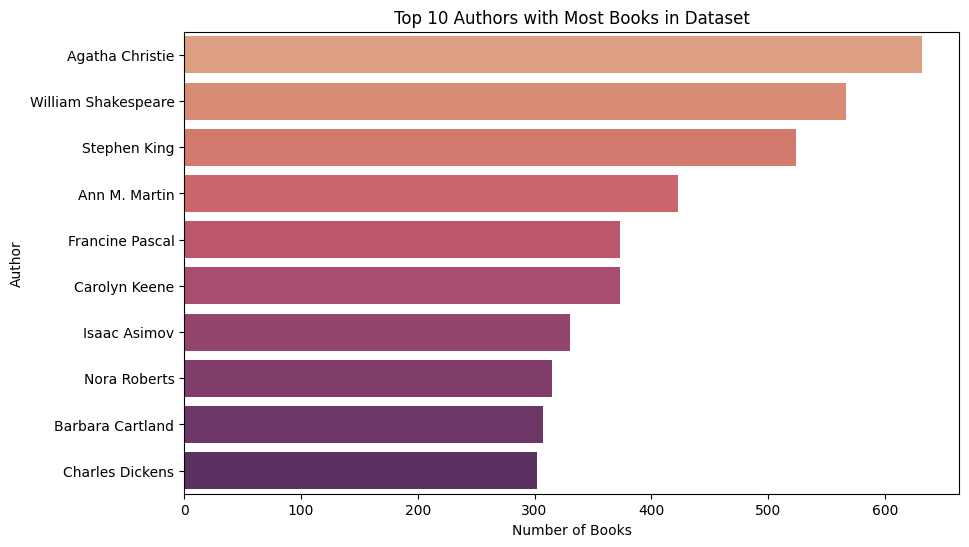

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count number of unique books (ISBNs) per author
author_book_counts = books.groupby('Author')['ISBN'].nunique().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(y=author_book_counts.index, x=author_book_counts.values, palette='flare')
plt.title("Top 10 Authors with Most Books in Dataset")
plt.xlabel("Number of Books")
plt.ylabel("Author")
plt.show()


Auhtors with most Average Ratings

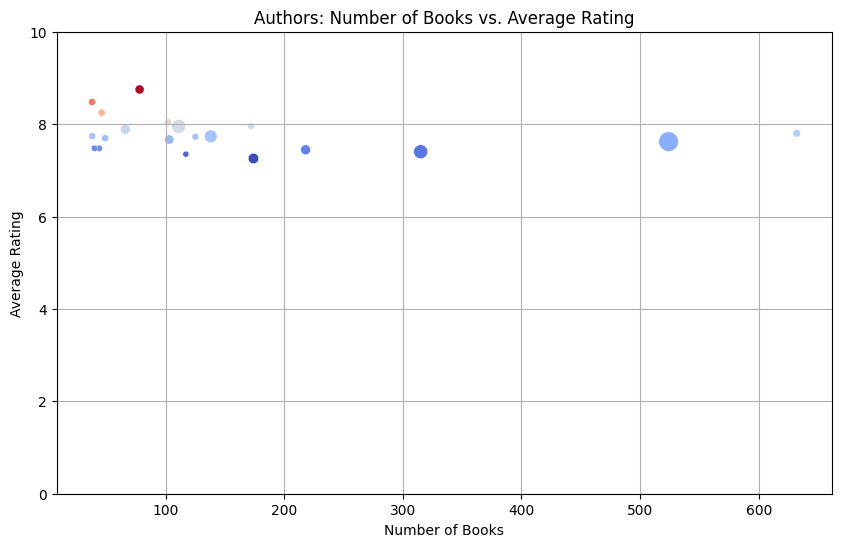

In [40]:
# Merge ratings with books
merged = pd.merge(sampled_ratings, books, on='ISBN')

# Count number of unique books per author
book_counts = books.groupby('Author')['ISBN'].nunique().reset_index()
book_counts.columns = ['Author', 'Num_Books']

# Compute average rating and total ratings per author
rating_stats = merged.groupby('Author').agg({
    'Rating': ['mean', 'count']
}).reset_index()
rating_stats.columns = ['Author', 'Avg_Rating', 'Num_Ratings']

# Merge both
author_summary = pd.merge(book_counts, rating_stats, on='Author')

# Filter authors with at least 3 books and 20 ratings
filtered = author_summary[(author_summary['Num_Books'] >= 3) & (author_summary['Num_Ratings'] >= 20)]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered,
    x='Num_Books',
    y='Avg_Rating',
    size='Num_Ratings',
    hue='Avg_Rating',
    palette='coolwarm',
    legend=False,
    sizes=(20, 200)
)
plt.title("Authors: Number of Books vs. Average Rating")
plt.xlabel("Number of Books")
plt.ylabel("Average Rating")
plt.ylim(0, 10)
plt.grid(True)
plt.show()